In [1]:
import praw
import regex as re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
import sklearn

Matplotlib created a temporary cache directory at /tmp/matplotlib-miy9g9hg because the default path (/home/jovyan/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Connect to Reddit API

In [ ]:
clientid = '-----------'
client_secret = '---------------'
user_agent = "script:reddit-sentiment-analyzer:v1.0 (by u/-------)"

In [3]:
reddit = praw.Reddit(
    client_id=clientid,
    client_secret=client_secret,
    user_agent=user_agent
)

In [4]:
print(reddit.read_only)
# Output: True

True


# Assigns a Target Sub that might be useful to learn how the general sentiment around a topic

In [5]:
tar_sub = 'datacenter'

- Using our reddit instance look in the `tar_sub` for all time and sort the post by the number of upvotes in descending order
- In each comment look through and find if any of the keywords are in it
- lower case them for easier searching
- build a dataframe 

In [6]:
import pandas as pd

battery_terms = ['battery', 'batteries', 'lithium', 'li-ion', 'sodium', 'lead', 'acid', 'ups']
data = []
seen_comments = set()

for term in battery_terms:
    for submission in reddit.subreddit(tar_sub).search(term, sort="top", time_filter="all"):
        submission.comments.replace_more(limit=0)
        for comment in submission.comments.list():
            if comment.id in seen_comments:
                continue
            text = comment.body.lower()
            matched_terms = [bt for bt in battery_terms if bt in text]
            if matched_terms:
                data.append({
                    'comment_id': comment.id,
                    'author': str(comment.author),
                    'text': text,
                    'matched_terms': matched_terms,
                    'submission_id': submission.id,
                    'submission_title': submission.title
                })
                seen_comments.add(comment.id)

# Convert to DataFrame
df = pd.DataFrame(data)


- Use the `VADER` sentiment analyzer to conduct out sentiment analysis
    - `VADER` will score each word in the comment
        - good = + 1.9
        - good!!!! = +2.3
        - bad = - 2.5
        - Extremely Bad = -3
        - awesome = +3.1
    - Output from `VADER` will have the proprtion of posivtive and negative sentment in the text and produced a normalized value `compund`
    - We'll apply the label marking it as net positive or net negative response based on the `compound` score

In [7]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()


In [8]:
# Apply VADER to each comment's text
df['sentiment'] = df['text'].apply(lambda x: analyzer.polarity_scores(x))


In [9]:
df = pd.concat([df.drop('sentiment', axis=1), df['sentiment'].apply(pd.Series)], axis=1)


In [10]:
def get_label(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment_label'] = df['compound'].apply(get_label)


In [11]:
df.head(3)

,comment_id,author,text,matched_terms,submission_id,submission_title,neg,neu,pos,compound,sentiment_label
0,g0bu3y5,ghostalker47423,"do a visual inspection, and if you see any lea...",[batteries],i3jdwl,Inheriting a 30 kVA UPS with 2 strings of 24 b...,0.084,0.873,0.043,-0.4215,negative
1,g0diub1,Redebo,disconnect the battery strings via the associa...,"[battery, batteries, ups]",i3jdwl,Inheriting a 30 kVA UPS with 2 strings of 24 b...,0.011,0.889,0.100,0.8366,positive
2,g0dtxqg,letsbebuns,the batteries should be removed based on age. ...,"[batteries, lead, acid, ups]",i3jdwl,Inheriting a 30 kVA UPS with 2 strings of 24 b...,0.029,0.971,0.000,-0.2617,negative


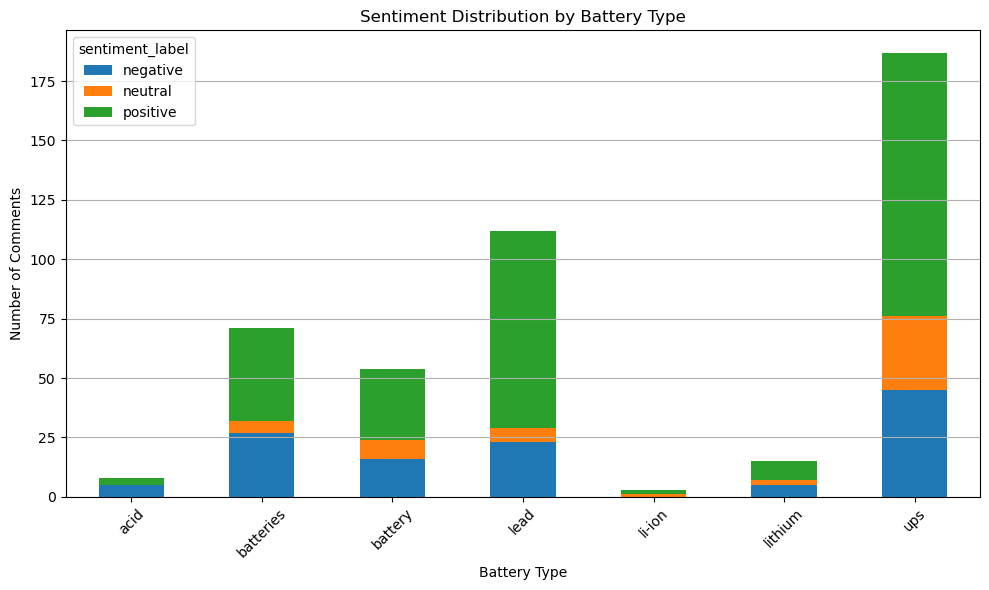

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Simulate a sample of the df for visualization
data = {
    'matched_terms': df['matched_terms'],
    'sentiment_label': df['sentiment_label']
}

df = pd.DataFrame(data)

# Explode matched_terms to allow grouping by single term
df_exploded = df.explode('matched_terms')

# Count sentiment labels per battery type
sentiment_counts = df_exploded.groupby(['matched_terms', 'sentiment_label']).size().unstack(fill_value=0)

# Plot the sentiment distribution per battery type
sentiment_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Sentiment Distribution by Battery Type')
plt.xlabel('Battery Type')
plt.ylabel('Number of Comments')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')

plt.show()